In [1]:
%install-location $cwd/installed-packages
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/saeta/Just", from: "0.7.2")' Just
%install '.package(url: "https://github.com/latenitesoft/NotebookExport", from: "0.5.0")' NotebookExport

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/saeta/Just", from: "0.7.2")
		Just
	.package(url: "https://github.com/latenitesoft/NotebookExport", from: "0.5.0")
		NotebookExport
With SwiftPM flags: []
Working in: /tmp/tmpo4_4p3cd/swift-install
[1/11] Compiling Path Path+StringConvertibles.swift
[2/11] Compiling Path Path->Bool.swift
[3/11] Compiling Path Path+ls.swift
[4/11] Compiling Path Path+Codable.swift
[5/11] Compiling Path Path+CommonDirectories.swift
[6/11] Compiling Path Path+FileManager.swift
[7/11] Compiling Path Extensions.swift
[8/11] Compiling Path Path+Attributes.swift
[9/11] Compiling Path Path.swift
[10/12] Merging module Path
[11/12] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[12/13] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


# Getting the MNIST Dataset

In [2]:
//export
import Foundation
import Just
import Path
import TensorFlow

In [3]:
//export

// Using the Process class, your program can run another program as a subprocess
// and can monitor that program’s execution.

// Pipe objects provide an object-oriented interface for accessing pipes.
// A Pipe object represents both ends of a pipe and enables communication through the pipe.

public extension String {
    @discardableResult
    func shell(_ args: String...) -> String
    {
        let (task, pipe) = (Process(), Pipe())
        task.executableURL = URL(fileURLWithPath: self)
        (task.arguments, task.standardOutput) = (args, pipe)
        do { try task.run() }
        catch { print("Unexpected error: \(error).") }
        
        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

In [4]:
print("/bin/ls".shell("-lh"))

total 32K
-rw-r--r-- 1 alex alex  14K Jun 30 18:27 00_MNISTLoader.ipynb
-rw-r--r-- 1 alex alex 3.6K Jun 29 18:13 01_Timer.ipynb
drwxr-xr-x 2 alex alex 4.0K Jun 29 17:54 data
drwxr-xr-x 4 alex alex 4.0K Jun 29 18:13 exports
drwxr-xr-x 4 alex alex 4.0K Jun 29 17:58 installed-packages



The following code uses the Just library, https://github.com/saeta/Just.

In [5]:
//export
public func downloadFile(_ url: String, dest: String? = nil, force: Bool = false) {
    let destName = dest ??
                  (Path.cwd/"data"/url.split(separator: "/").last!).string
    
    let urlDest = URL(
        fileURLWithPath:
        (dest ?? 
        (Path.cwd/url.split(separator: "/").last!).string)
    )
    
    if !force && Path(destName)!.exists { return }

    print("Downloading \(url)...")

    if let cts = Just.get(url).content {
        do    { try cts.write(to: URL(fileURLWithPath:destName)) }
        catch { print("Can't write to \(urlDest).\n\(error)") }
    } else {
        print("Can't reach \(url)")
    }
    
    print("Done!")
}

In [6]:
downloadFile("https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz")

In [7]:
//export
protocol ConvertibleFromByte: TensorFlowScalar {
    init(_ d: UInt8)
}

extension Float : ConvertibleFromByte {}
extension Int32 : ConvertibleFromByte {}

extension Data {
    func asTensor<T: ConvertibleFromByte>() -> Tensor<T> {
        return Tensor(map(T.init))
    }
}

func loadMNIST<T: ConvertibleFromByte>
        (training: Bool, labels: Bool, path: Path, flat: Bool) -> Tensor<T> {
    let split = training ? "train" : "t10k"
    let kind = labels ? "labels" : "images"
    let batch = training ? 60000 : 10000
    let shape: TensorShape = labels ? [batch] : (flat ? [batch, 784] : [batch, 28, 28])
    let dropK = labels ? 8 : 16
    let baseUrl = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    let fname = split + "-" + kind + "-idx\(labels ? 1 : 3)-ubyte"
    let file = path/fname
    if !file.exists {
        downloadFile("\(baseUrl)\(fname).gz", dest:(path/"\(fname).gz").string)
        "/bin/gunzip".shell("-fq", (path/"\(fname).gz").string)
    }
    let data = try! Data(contentsOf: URL(fileURLWithPath: file.string)).dropFirst(dropK)
    if labels { return data.asTensor() }
    else      { return data.asTensor().reshaped(to: shape) }
}

public func loadMNIST(path: Path, flat: Bool = false) 
        -> (Tensor<Float>, Tensor<Int32>, Tensor<Float>, Tensor<Int32>) {
    // (data, labels, data, labels)
    return (
        loadMNIST(training: true,  labels: false, path: path, flat: flat) / 255.0,
        loadMNIST(training: true,  labels: true,  path: path, flat: flat),
        loadMNIST(training: false, labels: false, path: path, flat: flat) / 255.0,
        loadMNIST(training: false, labels: true,  path: path, flat: flat)
    )
}

public let MNISTPath = Path.cwd/"data"

In [8]:
let (xTrain, yTrain, xValid, yValid) = loadMNIST(path: MNISTPath)
xTrain.shape

▿ [60000, 28, 28]
  ▿ dimensions : 3 elements
    - 0 : 60000
    - 1 : 28
    - 2 : 28


In [9]:
let (xTrain, yTrain, xValid, yValid) = loadMNIST(path: MNISTPath, flat: true)
xTrain.shape

▿ [60000, 784]
  ▿ dimensions : 2 elements
    - 0 : 60000
    - 1 : 784


# Python you are not forgotten!

In [10]:
#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [11]:
let plt = Python.import("matplotlib.pyplot")

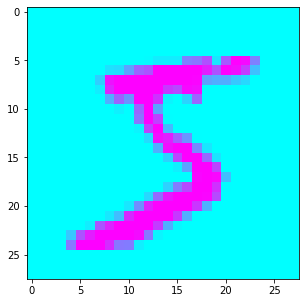

None


In [12]:
let img = xTrain[0].makeNumpyArray().reshape(28, 28)
plt.figure(figsize: [5, 5])
plt.show(
    plt.imshow(img, cmap: "cool")
)

In [13]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"00_MNISTLoader.ipynb")
print(exporter.export(usingPrefix: "exports/e_"))

success
